In this notebook we aim to implement Karpathy's lecture on `nanoGPT`. Here however we apply it not to generating Shakespeare, but household daily energy demand time-series, trained from the IDEAL open dataset. 

In [1]:
# we start by loading the data that we will use to train the model.
import pandas as pd
data = pd.read_csv('/Users/eoghan/repos/makemore/data/daily_demand_and_weather.csv')
data.head()

,household_id,datetime,maxtemp,mintemp,conditions,day_of_week,is_weekend,is_bank_holiday,mean_rounded_gas_pulse,mean_rounded_electric_combined
0,100,2017-03-07,10.0,4.0,Chance of Rain,1.0,False,False,5277.0,343.0
1,100,2017-03-08,11.0,5.0,Chance of Rain,2.0,False,False,6832.0,253.0
2,100,2017-03-09,11.0,3.0,Chance of Rain,3.0,False,False,1283.0,203.0
3,100,2017-03-10,10.0,7.0,Overcast,4.0,False,False,4168.0,222.0
4,100,2017-03-11,13.0,6.0,Chance of Rain,5.0,True,False,1264.0,243.0


In [47]:
# to start, we will just work with the gas data, later we will complexify things by adding in electricity and weather, and information about the calender day
raw_gas = data['mean_rounded_gas_pulse'].copy()
# what is the length of the dataset?
len(raw_gas)

71606

So not that many datapoints, so our model will very easily over-fit this training data. But that's okay at this stage, this is mainly about creating a simple example, to learn, to make mistakes, to incrementally add features to the model, and which we can then subsequently work with more complex data later.

Text(0, 0.5, 'Wh')

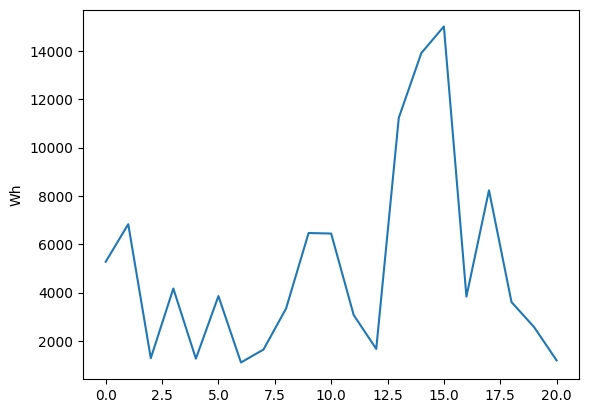

In [4]:
# plot a couple of weeks of data
import matplotlib.pyplot as plt
plt.plot(raw_gas[0:7*3])
# y-label Wh
plt.ylabel('Wh')

Now, we are dealing with a different type of data than typically used for GPT, which is text. So we are going to need to convert our numeric time-series, into indices, from 0 to the length of the models 'vocabulary'. 

In [23]:
# how many unique values are there in the dataset?
len(raw_gas.unique())

11292

In [19]:
raw_gas.describe()

count    59655.000000
mean      4158.431498
std       5681.697170
min          0.000000
25%       1327.000000
50%       2855.000000
75%       5123.500000
max      99805.000000
Name: mean_rounded_gas_pulse, dtype: float64

In [48]:
# set all values less than 0 to 0
raw_gas.loc[raw_gas < 0] = 0

In [49]:
# set unreasonably high values to Nan
import numpy as np
raw_gas.loc[raw_gas > 100000] = np.nan

In [24]:
raw_gas.isna().sum(), len(raw_gas)

(11951, 71606)

In [50]:
# so let's simplify the dataset, and round raw_gas to the nearest 10, just to reduce the size of our vocabulary. 
raw_gas = raw_gas.round(-1)
len(raw_gas.unique())

2454

Okay, so we've got a vocabulary of 2454. And now we can create a mapping for these unique values. 

In [51]:
# first however we need to deal with missing values, in particular we need to replace any nan with a special character <M> which will represent missing values
raw_gas = raw_gas.astype(str).replace('nan', '<M>')

In [53]:
unique_values = raw_gas.unique()


In [54]:
unique_values.sort()
print(unique_values[-10:])

['9930.0' '9940.0' '99470.0' '9950.0' '9960.0' '9970.0' '9980.0' '99800.0'
 '9990.0' '<M>']


In [57]:
#create a mapping from values to indices
vtoi = {val:i for i, val in enumerate(unique_values)}
itov = {i:val for i, val in enumerate(unique_values)}

encode = lambda v: [vtoi[val] for val in v] # take a list of values and return a list of indices
decode = lambda l: [float(itov[i]) for i in l] # take a list of indices and return a list of values

print(raw_gas[:10])
print(encode(raw_gas[:10]))
print(decode(encode(raw_gas[:10])))


0    5280.0
1    6830.0
2    1280.0
3    4170.0
4    1260.0
5    3860.0
6    1110.0
7    1640.0
8    3340.0
9    6470.0
Name: mean_rounded_gas_pulse, dtype: object
[1784, 2031, 304, 1588, 283, 1530, 122, 648, 1405, 1973]
[5280.0, 6830.0, 1280.0, 4170.0, 1260.0, 3860.0, 1110.0, 1640.0, 3340.0, 6470.0]


In [61]:
encode(['<M>', '<M>'])

[2453, 2453]

In [63]:
# and now we can encode the entire dataset and store it as a torch tensor
import torch
data = torch.tensor(encode(raw_gas), dtype=torch.long)
print(data.dtype, data.shape)
print(data[:100])

torch.int64 torch.Size([71606])
tensor([1784, 2031,  304, 1588,  283, 1530,  122,  648, 1405, 1973, 1967, 1332,
         676,  137,  421,  526, 1525, 2220, 1474, 1184,  208, 1791, 1666,  813,
        1320,  813, 1903,   88, 1914, 1948,  853,  197,  638,  430,  996, 1361,
         860, 1082, 2426, 1110, 1797,   68,  561, 1134,  132, 1050, 1326, 1439,
        1660, 1739,  107,  304,  369, 1611, 1555,  165, 1254,   12, 1594, 1165,
         666, 1785, 1364,  684,  794,  821,  283,  740,  941, 1719, 1213, 1572,
        1165,  996, 1494, 1349, 1549, 1673,   33,   77,   66, 1344, 1302,  378,
        2214,  709, 1059,  514, 1618,  959, 1272, 1368, 2352, 2441, 2211, 1964,
        2010, 1082, 1293, 2095])


In [64]:
# let's split the data into train and validation splits 0.9 / 0.1
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

In [82]:
test1 = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
test2 = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
stack = torch.stack([test1, test2], dim=0)
stack, stack.shape

(tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
         [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]]),
 torch.Size([2, 11]))

In [65]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[1216, 1224, 1508, 1474, 1337, 1410, 1462, 1213],
        [2453, 1232, 1724, 1891, 2324, 2453, 2453, 2453],
        [1851,  568, 2453,   67, 1626, 2261,  826, 2440],
        [1518, 1518, 1633, 1491,   77, 1555,    1, 2381]])
targets:
torch.Size([4, 8])
tensor([[1224, 1508, 1474, 1337, 1410, 1462, 1213, 1477],
        [1232, 1724, 1891, 2324, 2453, 2453, 2453, 1587],
        [ 568, 2453,   67, 1626, 2261,  826, 2440,  254],
        [1518, 1633, 1491,   77, 1555,    1, 2381,   33]])
----
when input is [1216] the target: 1224
when input is [1216, 1224] the target: 1508
when input is [1216, 1224, 1508] the target: 1474
when input is [1216, 1224, 1508, 1474] the target: 1337
when input is [1216, 1224, 1508, 1474, 1337] the target: 1410
when input is [1216, 1224, 1508, 1474, 1337, 1410] the target: 1462
when input is [1216, 1224, 1508, 1474, 1337, 1410, 1462] the target: 1213
when input is [1216, 1224, 1508, 1474, 1337, 1410, 1462, 1213] the target: 1477
wh